In [6]:
import feats
import utils
import constants
import transactions

import os
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
from imp import reload
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VAR
from scipy.spatial.distance import euclidean
from sklearn.utils.extmath import cartesian
from sklearn.feature_extraction.text import CountVectorizer
from pandas.tools.plotting import lag_plot, autocorrelation_plot

In [3]:
uo = tle.get_users_orders('prior')

In [4]:
up_pair = uo[['user_id', 'product_id']].drop_duplicates()

In [ ]:
order_products_train = tle.get_orders_items('train')

In [33]:
order_products_prior = tle.get_orders_items('prior')
orders = tle.get_orders()
products = tle.get_items('products')
aisles = tle.get_items('aisles')
departments = tle.get_items('departments')

In [12]:
products_details = pd.merge(products, tle.craft_feat_product(), on = ['product_id'], how = 'right')

## <font color=red> 1 None订单 </font>

In [6]:
order_is_None = order_products_train.groupby(['order_id'])['reordered'].sum().reset_index()

In [11]:
len(order_is_None[order_is_None.reordered == 0]) / len(order_is_None[order_is_None.reordered > 0])

0.07015912631415824

In [19]:
a = pd.merge(order_is_None, orders, how = 'left', on = ['order_id'])

#### prior、train订单

In [65]:
order_products_all = pd.concat([order_products_prior, order_products_train], axis = 0)

## 2 How many products do users buy each time
- 每张订单的商品数目

In [21]:
grouped = order_products_prior.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()

In [22]:
grouped.add_to_cart_order.describe()

count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: add_to_cart_order, dtype: float64

## 3 Do users purchase different numbers of products each time?
- 用户每次购买的商品数目一样麽

In [23]:
grouped = pd.merge(grouped,
         orders,
         on = ['order_id'],
         how = 'left')[['user_id', 'add_to_cart_order', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]

In [24]:
grouped = grouped.sort_values(['user_id', 'order_number'])

In [25]:
grouped.columns = ['user_id', 
                   'num_products', 
                   'order_number', 
                   'order_dow',
                   'order_hour_of_day', 
                   'days_since_prior_order']

In [18]:
user_num_product = grouped.groupby(['user_id'])['num_products'].agg({'mean':'mean', 'std':'std'})

In [ ]:
with open(DATA_DIR + 'user_num_product_stat.pkl', 'wb') as f:
    pickle.dump(user_num_product, f, pic)

In [3]:
with open(constants.FEAT_DATA_DIR + 'user_num_product_stat.pkl', 'rb') as f:
    user_num_product = pickle.load(f)

In [7]:
user_num_product['std'].describe()

count    206209.000000
mean          4.266349
std           2.675061
min           0.000000
25%           2.345208
50%           3.781534
75%           5.609516
max          44.747439
Name: std, dtype: float64

## 4 Reorder Rate 
- 每张订单中重复购买商品比例

In [26]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]

In [27]:
prior_reorder_rate = order_products_prior.groupby(['order_id'])['reordered'] \
                                         .aggregate({'reorder_pnum':'sum', 'pnum':'count'})

In [28]:
prior_reorder_rate['reorder_rate'] = prior_reorder_rate['reorder_pnum'] / prior_reorder_rate['pnum']

In [29]:
prior_reorder_rate.reset_index(inplace=True)

In [30]:
prior_orders = orders[orders.eval_set == 'prior']

In [31]:
prior_orders = pd.merge(prior_orders, prior_reorder_rate,
                        on = ['order_id'], how = 'left')

In [32]:
prior_orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_up_to_last,pnum,reorder_pnum,reorder_rate
0,2539329,1,prior,1,2,8,0.0,190.0,5,0,0.000
1,2398795,1,prior,2,3,7,15.0,175.0,6,3,0.500
2,473747,1,prior,3,3,12,21.0,154.0,5,3,0.600
3,2254736,1,prior,4,4,7,29.0,125.0,5,5,1.000
4,431534,1,prior,5,4,15,28.0,97.0,8,5,0.625


In [33]:
user_reorder_est = prior_orders.groupby(['user_id'])['reorder_pnum']\
                               .aggregate({'reorder_pnum_mean':'mean', 
                                           'reorder_pnum_std':'std'}).reset_index()

In [34]:
user_reorder_est = user_reorder_est[['user_id', 'reorder_pnum_mean', 'reorder_pnum_std']]

In [35]:
with open(constants.FEAT_DATA_DIR + 'user_reorder_est.pkl', 'wb') as f:
    pickle.dump(user_reorder_est, f, pickle.HIGHEST_PROTOCOL)

In [3]:
with open(constants.FEAT_DATA_DIR + 'user_reorder_est.pkl', 'rb') as f:
    user_reorder_est = pickle.load(f)

In [10]:
user_reorder_est.reorder_pnum_std.describe()

count    206209.000000
mean          3.018932
std           2.104826
min           0.000000
25%           1.511858
50%           2.563480
75%           4.029652
max          31.210495
Name: reorder_pnum_std, dtype: float64

## 5 Products User Bought Previously

In [ ]:
users_products = pd.merge(prior_orders, order_products_prior, on = ['order_id'], how = 'left')

In [20]:
users_products = users_products.groupby(['user_id'])['product_id'].apply(list).reset_index()

In [22]:
with open(DATA_DIR + 'user_product.pkl', 'wb') as f:
    pickle.dump(users_products, f, pickle.HIGHEST_PROTOCOL)

In [3]:
with open(constants.FEAT_DATA_DIR + 'user_product.pkl', 'rb') as f:
    users_products = pickle.load(f)

In [6]:
l = users_products.product_id.apply(len)

In [10]:
l.describe()

count    206209.000000
mean        157.289396
std         204.208233
min           3.000000
25%          39.000000
50%          83.000000
75%         188.000000
max        3725.000000
Name: product_id, dtype: float64

## 6 Candidate Products
- last purchase
- reorder items
- all items that has high reorder rate
- items that are added to cart first

In [394]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']

## 7 Time of orders

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


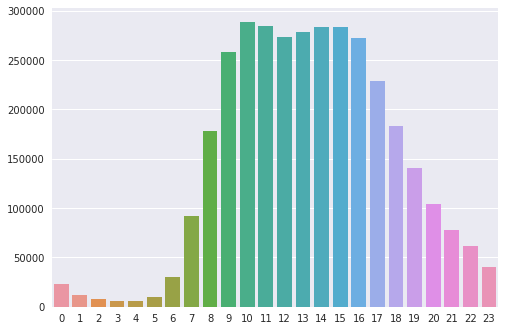

In [13]:
grouped = orders.order_hour_of_day.value_counts()
sns.set_style('darkgrid')
sns.barplot(grouped.index, grouped.values)
plt.show()

## 8 Topic Distance
- user VS product <font color=blue>prior中的所有(u,p)对</font>
- <font color=red>latest order VS product</font> <font color=blue>通过LDA-transform来构造</font>

In [15]:
# term-frequency matrix construct
orders = pd.read_csv(DATA_DIR + 'orders.csv')

users_orders = pd.merge(order_products_prior, orders[['user_id', 'order_id']], 
                        on = ['order_id'], how = 'left')

users_products_matrix = users_orders.groupby(['user_id'])['product_id'].apply(series_to_str)

tf = CountVectorizer(analyzer = 'word', lowercase = False, max_df=0.95, min_df=2,)
tf_matrix = tf.fit_transform(users_products_matrix.values)
tf_feature_names = tf.get_feature_names()

with open(DATA_DIR + 'tf.model', 'wb') as f:
    pickle.dump(tf, f, pickle.HIGHEST_PROTOCOL)

In [56]:
#订单的Topic, tf为CountVector，将文档转化为term-frequency矩阵
op = order_products_prior.groupby(['order_id'])['product_id'].apply(series_to_str)
topic_order = pd.DataFrame(lda.transform(tf.transform(op.values)), columns= ["topic_%d"%x for x in range(10)])
topic_order['order_id'] = op.index.values
with open(DATA_DIR + 'order_topic_norm.pkl', 'wb') as f:
    pickle.dump(topic_order_norm, f, pickle.HIGHEST_PROTOCOL)

In [65]:
up_distance = pd.merge(users_orders[['user_id', 'product_id']].drop_duplicates(),
                       user_topic, 
                       on = ['user_id'],
                       how = 'left')
up_distance.columns = ['user_id', 'product_id'] + ["u_topic_%d"%x for x in range(10)] 
up_distance = pd.merge(up_distance,
                       topic_product, 
                       on = ['product_id'],
                       how = 'left')
up_distance.columns = ['user_id', 'product_id'] + ["u_topic_%d"%x for x in range(10)] + ["p_topic_%d"%x for x in range(10)] 

In [87]:
def cal_up_distance(subf):
    u_topic = subf[["u_topic_%d"%x for x in range(10)]]
    p_topic = subf[["p_topic_%d"%x for x in range(10)]]
    upd = euclidean(u_topic, p_topic)
    return upd

In [92]:
# 3 hours
up_distance['up_dis'] = up_distance.apply(cal_up_distance, axis = 1)

CPU times: user 3h 40min 56s, sys: 2min 4s, total: 3h 43min
Wall time: 3h 49min 41s


In [94]:
up_distance = up_distance[['user_id', 'product_id', 'up_dis']]
with open(DATA_DIR + 'upd_feat.pkl', 'wb') as f:
    pickle.dump(up_distance, f, pickle.HIGHEST_PROTOCOL)

## 9 Order Topic Construct
- <font color=red>countvector， lda transform</font>
- 由商品的Topic构造订单的Topic表达
- 商品加入购物车的次序？？？ 先忽视次序
- 每个用户学习：加购物车次序 VS 重购？ VS下张订单的Topic？？

In [309]:
order_topic = pd.merge(order_products_prior[['order_id', 'product_id']],
                       topic_product,
                       on = ['product_id'],
                       how = 'inner')#throw stop words

In [312]:
order_topic = order_topic.groupby(['order_id'])[["topic_%d"%x for x in range(10)]].sum().reset_index()

In [314]:
unorm = order_topic[["topic_%d"%x for x in range(10)]].values

In [315]:
order_topic[["topic_%d"%x for x in range(10)]] = unorm / unorm.sum(axis = 1)[:,np.newaxis]

In [301]:
len(order_products_prior.product_id.unique())

49677

In [302]:
len(topic_product.product_id.unique())

49502

## 10  XGBoost Feature Preparation
- 正负样本10:1

In [1]:
import constants, utils, transactions, feats
from imp import reload

In [3]:
tle = transactions.TransLogExtractor(constants.RAW_DATA_DIR, constants.FEAT_DATA_DIR)

In [33]:
train_none = feats.make_train_or_test_none(tle, 'train')

13307953


In [34]:
test_none = feats.make_train_or_test_none(tle, 'test')

13307953


In [4]:
train = feats.make_train_or_test(tle, 'train')

13307953


In [ ]:
utils.check_inf_nan(train[up_cols])

In [ ]:
utils.check_inf_nan(train[ua_cols])

In [ ]:
utils.check_inf_nan(train[ud_cols])

In [7]:
utils.check_inf_nan(train[p_cols])

Checking inf ...
Series([], dtype: float64)
Checking NAN ...
Index([], dtype='object')


True

In [ ]:
utils.check_inf_nan(train[a_cols])

In [ ]:
utils.check_inf_nan(train[d_cols])

In [ ]:
utils.check_inf_nan(train[ctx_cols])

In [ ]:
utils.check_inf_nan(train[topic_cols])

## 11 LSTM Feature Preparation

- (u,p,t)
- 间隔、加购物车次序作为Symbol
   
   - 次序
        - 1
        - 2
        - 3
        - 4-6
        - 7-11
        - 12 ——
        
   - 间隔
        - 1 - 7
        - 8 - 16
        - 17 - 33
        - 34
        - 100 NAN
        
- 实现
     - Encoder两个列, 总共30种符号
     - Cartesian查表
     - 直接数值

In [4]:
users_orders = tle.get_users_orders('prior')

In [ ]:
product_feat = tle.craft_feat_item('products')

In [255]:
user_feat = tle.craft_feat_user()

In [256]:
users_orders = pd.merge(users_orders, product_feat[['product_id', 'p_reorder_probability']], on=['product_id'], how='left')

In [257]:
users_orders = pd.merge(users_orders, user_feat[['user_id', 'u_total_reorders']], on=['user_id'], how='left')

In [258]:
def encode_numeric(row, bins):
    '''
    convert numeric variable into binned category
    bins = [b1, b2, b3, b4]
    '''
    index = ~(row < bins)
    return [bins[index][-1]]

In [321]:
add2cart_bins = np.array([1, 2, 3, 4, 7, 12], dtype=float) # 6
interval_bins = np.array([-1, 4, 8, 17, 34], dtype=float)# 5
p_reorder_bins = np.array([0.0, 0.20, 0.38, 0.53], dtype=float)# 4
u_reorder_bins = np.array([0, 10, 33, 101], dtype=float)# 4

In [ ]:
%%time
users_orders = users_orders.sort_values(['user_id', 'product_id', 'order_number'], ascending = False)
users_orders['up_interval'] = users_orders.groupby(['user_id', 'product_id'])['days_up_to_last'].diff()
users_orders.up_interval.fillna(-1, inplace=True)
users_orders['up_interval_sym'] = users_orders.up_interval.apply(lambda x: encode_numeric(x, interval_bins))
users_orders['up_add2cart_order_sym'] = users_orders.add_to_cart_order.apply(lambda x: encode_numeric(x, add2cart_bins))

In [265]:
users_orders['p_reorder_prob_sym'] = users_orders.p_reorder_probability.apply(lambda x: encode_numeric(x, p_reorder_bins))
users_orders['u_reorder_sym'] = users_orders.u_total_reorders.apply(lambda x:encode_numeric(x, u_reorder_bins))

In [322]:
feat_card = [add2cart_bins, interval_bins, p_reorder_bins, u_reorder_bins]

In [323]:
feat_cartesian = cartesian(feat_card)

In [327]:
users_orders['up_card'] = users_orders.up_add2cart_order_sym + users_orders.up_interval_sym + users_orders.p_reorder_prob_sym + users_orders.u_reorder_sym

In [337]:
def encode_cartesian(row, feat_cartesian):
    '''
        lookup table
        turn a group of categorical variable into a symbol
    '''
    sym = np.where(np.all(row == feat_cartesian,axis=1))[0][0] + 1
    return sym

In [340]:
%%time
users_orders['up_airr_sym'] = users_orders.up_card.apply(lambda x: encode_cartesian(x, feat_cartesian))

CPU times: user 5min 54s, sys: 6.16 s, total: 6min
Wall time: 5min 59s


In [352]:
up_airr_sym = users_orders[['user_id', 'product_id', 'order_number', 'up_airr_sym']]

In [354]:
up_airr_sym.sort_values(['user_id', 'product_id', 'order_number'], inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [356]:
up_airr_sym_list = up_airr_sym.groupby(['user_id', 'product_id'])['up_airr_sym'].apply(list).reset_index()

In [358]:
with open(constants.FEAT_DATA_DIR + 'up_airr_sym.pkl', 'wb') as f:
    pickle.dump(up_airr_sym_list, f, pickle.HIGHEST_PROTOCOL)

## <font color=red> (u,p)对时间间隔预测</font>

Time Series Forcasting 问题

- 方案1：用之前的Timestep对当前值进行回归预测
- 方案2：<font color=red>LSTM</font> 仅仅包含购买间隔信息
    - 样本（sample）:(u,p,oid)
    - 特征（feature）:两次购买之间的间隔
   
- 预处理
    - 只出现一次的(u,p)无法计算间隔，NAN 丢弃
    - p_purchase_interval:距离下次购买的时间
    - 间隔为0的删除，同一天内购买两次视为一次
    - 为了training,间隔序列的长度 >=2 即(u,p)在prior里至少出现3次

In [3]:
users_orders = tle.get_users_orders(prior_or_train='prior')

In [4]:
a = users_orders[['user_id', 'order_number', 'product_id', 'days_up_to_last', 'p_purchase_interval']].sort_values(['user_id', 'order_number', 'p_purchase_interval'])

In [5]:
del users_orders

In [10]:
a.sort_values(['user_id', 'product_id', 'order_number'], ascending=False, inplace=True)

In [11]:
%%time
a['up_interval'] = a.head(1000).groupby(['user_id', 'product_id'])['days_up_to_last'].diff()

CPU times: user 704 ms, sys: 136 ms, total: 840 ms
Wall time: 839 ms


In [13]:
a.sort_values(['user_id', 'product_id'])

,user_id,order_number,product_id,days_up_to_last,p_purchase_interval,up_interval
24181266,1,10,196,14.0,-1.0,NaN
21760446,1,9,196,44.0,30.0,NaN
29474806,1,8,196,44.0,0.0,NaN
5212927,1,7,196,58.0,14.0,NaN
31927070,1,6,196,78.0,20.0,NaN
4089398,1,5,196,97.0,19.0,NaN
21376074,1,4,196,125.0,28.0,NaN
4488095,1,3,196,154.0,29.0,NaN
22742744,1,2,196,175.0,21.0,NaN
24076664,1,1,196,190.0,15.0,NaN


In [4]:
print("number of (u,p,t) tuples: %d"%len(users_orders))

number of (u,p,t) tuples: 32434489


In [ ]:
del users_orders # free memory usage

In [12]:
users_orders_intervals = users_orders.dropna() #throw away product_id bought only once

In [16]:
users_orders_intervals = users_orders_intervals[users_orders_intervals.p_purchase_interval > 0] # throw away record buy in the same day

In [18]:
users_orders_intervals = users_orders_intervals.sort_values(['user_id', 'product_id', 'order_number'])

In [19]:
%%time
up_interval_list = users_orders_intervals.groupby(['user_id', 'product_id'])['p_purchase_interval'].apply(list).reset_index()

CPU times: user 3min 48s, sys: 12.5 s, total: 4min
Wall time: 4min 1s


In [20]:
len(up_interval_list)

5279850

In [22]:
del users_orders_intervals # free memory usage

In [24]:
up_interval_list['len'] = up_interval_list.p_purchase_interval.apply(lambda x: len(x))

In [25]:
up_interval_list = up_interval_list[up_interval_list.len >= 2] # for train/test split 

In [ ]:
with open(constants.FEAT_DATA_DIR + 'up_interval_feat.pkl', 'wb') as f:
    pickle.dump(up_interval_list, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
len(up_interval_list)

In [ ]:
up_interval_list.len.describe()